## Classification Tree

Create a classification tree

 1. Import the data from a csv file 
 2. Create the predictor variables and the target variable
 3. Split the data into train and test dataset
 4. Fit a decision tree model on train data 
 5. Visualize the decision tree model
 6. Make Predictions and evaluate the performance


## Import the data

We will input raw data of a flow and port statistics from a CSV file. Predictor and target variables are created using this raw data. 

In [12]:
import pandas as pd

#read voip data
voip_flow = pd.read_csv('voip_FlowStats.csv', index_col=False).dropna().drop(columns="target")
#print(voip_flow.shape)
voip_port = pd.read_csv('voip_PortStats.csv', index_col=False).dropna()
voip_port = voip_port.drop(voip_port[pd.to_numeric(voip_port.port_no) > 10].index)
#print(voip_port.shape)
voip=pd.concat([voip_flow, voip_port], axis=1, join='inner')
voip["app_label"]=2  #voip
#voip.head(10)


#read video data
youtube_flow = pd.read_csv('youtube_FlowStats.csv', index_col=False).dropna().drop(columns="target")
youtube_port = pd.read_csv('youtube_PortStats.csv', index_col=False).dropna()
youtube_port = youtube_port.drop(youtube_port[pd.to_numeric(youtube_port.port_no) > 10].index)
youtube=pd.concat([youtube_flow, youtube_port], axis=1, join='inner')
youtube["app_label"]=1  #video


#read browse data
browse_flow = pd.read_csv('browse_FlowStats.csv', index_col=False).dropna().drop(columns="target")
browse_port = pd.read_csv('browse_PortStats.csv', index_col=False).dropna()
browse_port = browse_port.drop(browse_port[pd.to_numeric(browse_port.port_no) > 10].index)
browse=pd.concat([browse_flow, browse_port], axis=1, join='inner')
browse["app_label"]=3  #cbc


#read vimeo data
vimeo_flow =  pd.read_csv('vimeo_FlowStats.csv', index_col=False).dropna().drop(columns="target")
vimeo_port = pd.read_csv('vimeo_PortStats.csv', index_col=False).dropna()
vimeo_port = vimeo_port.drop(vimeo_port[pd.to_numeric(vimeo_port.port_no) > 10].index)
vimeo=pd.concat([vimeo_flow, vimeo_port], axis=1, join='inner')
vimeo["app_label"] = 1 #vimeo
vimeo.head(10)

hangout_flow =  pd.read_csv('hangout_FlowStats.csv', index_col=False).dropna().drop(columns="target")
hangout_port = pd.read_csv('hangout_PortStats.csv', index_col=False).dropna()
hangout_port = hangout_port.drop(hangout_port[pd.to_numeric(hangout_port.port_no) > 10].index)
hangout=pd.concat([hangout_flow, hangout_port], axis=1, join='inner')
hangout["app_label"] = 2 #hangout
#hangout.head(10)


#stack up in column
data=pd.concat([voip, youtube, browse, vimeo, hangout], axis=0, sort=False)
data.head(10)




feature_list = ['in_port', 'packets', 'bytes', 'duration_sec', 'port_no','rx_bytes', 'rx_pkts', 'tx_bytes','tx_pkts']
X = data[feature_list]
y = data.app_label


## Split the data into train and test dataset

Before we build a decision tree model, we need to split the data set into train and test data. A decision tree model uses the train data to learn the properties of data and the test data to estimate the model’s accuracy of the predictions.

From sklearn, we use the sub-library called model_selection, and import the train_test_split method. We will use 70% of the data set for training the model and a hold back of 30% for testing. We set the random_state parameter to a fixed number. This ensures that the data is split the same way every time and we get the same model output for each run. 

Another thing to keep in mind during splitting is to ensure that the test data is representative of the train data. This is done using stratify. We assign  stratify = y, so that it splits the data in same proportion as ‘y’. That means if ‘0’s were 45% and ‘1’s 55% in ‘y’, the train and test data will continue to have the same proportion of 45% and 55% of the class labels. 


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(2637, 9) (2637,)
(1131, 9) (1131,)


## Create classification tree model

We have used DecisionTreeClassifier from sklearn.tree to create the classification tree model. We choose to set min_samples_leaf to 5. 

In [14]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5) 
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We create the fit() method to train the classifier on the train dataset.

In [15]:
clf = clf.fit(X_train, y_train)

## Visualize the model

We now visualize the classification tree created in the step below using the graphviz and sklearn's tree package.

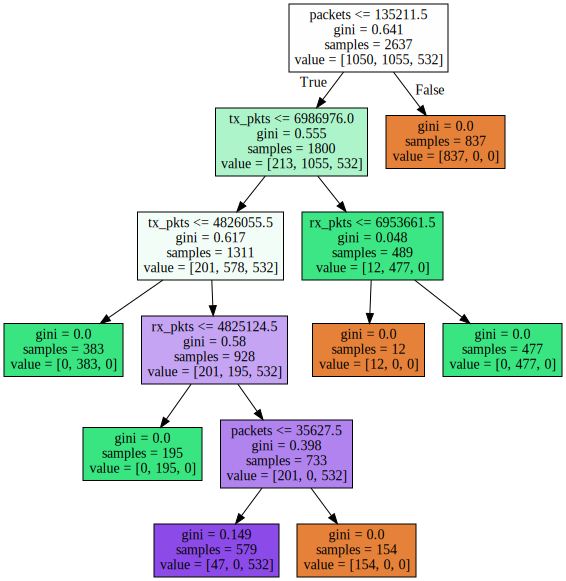

In [17]:
import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/academy/Documents/graphviz-2.38/release/bin/'
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/release/bin/'
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,filled=True,feature_names=feature_list)   
graphviz.Source(dot_data) 

As can be seen in the tree, every node contains some information: 
    
 1. the predictor variable used to split the data set: recall that X[0] is ADI, X[1] is RSI.  
 2. the value of gini impurity, 
 3. the number of data points available at that node and 
 4. the number of target variable data points belonging to each class, 1 and 0.

The left-most path leads to a pure node with 11 data points as ‘1’s, which can be used to define a long rule for a trading strategy. The decision rule can be paraphrased as ADX <= 32.446 and RSI <= 35.542. If during test, this condition is met for a  new data point, then, the model will predict a positive next day return for the stock.

## Make Predictions

Once we have trained the decision tree classifier, we make predictions on the test data. To make predictions, the predict method of
the DecisionTreeClassifier class is used.


In [18]:
y_pred = clf.predict(X_test)

In [19]:
from sklearn.externals import joblib
joblib.dump(clf, 'tree_qos.pkl', compress=9)

['tree_qos.pkl']

In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.981432360743


## Evaluate the Model Performance

Scikit-learn provides performance report for classification problems. The report prints  measures like precision, recall, F1-score and support for each class. Precision and recall indicate the quality of our predictions. The f1-score gives the harmonic mean of precision and recall. The support values are used as weights to compute the average values of precision, recall and F-1.

Anything above 0.5 is usually considered a good number. We have got an average recall of 0.65 which is good for this model.


In [21]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           1       1.00      0.95      0.98       450
           2       1.00      1.00      1.00       453
           3       0.92      1.00      0.96       228

   micro avg       0.98      0.98      0.98      1131
   macro avg       0.97      0.98      0.98      1131
weighted avg       0.98      0.98      0.98      1131



## Summary 

In this notebook, we saw how a decision tree model can be coded in Python to predict the next day stock returns. In the next section, we will learn to build a trading strategy using a regression tree model. For now, let us move to ipython and code the strategy.  
